# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [15]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.15.0
True


## Data loading functions

In [16]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # the size of the network input image

train_files = glob("D:/GITHUB/Dataset_CV/dvc/train/*.jpg")
test_files = glob("D:/GITHUB/Dataset_CV/dvc/test/*.jpg")

# upload the input image and pre-process it
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # preprocessing for VGG 16

# The function is a generator for downloading training data from disk
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# function-generator for downloading test images from disk
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Visualization examples for learning

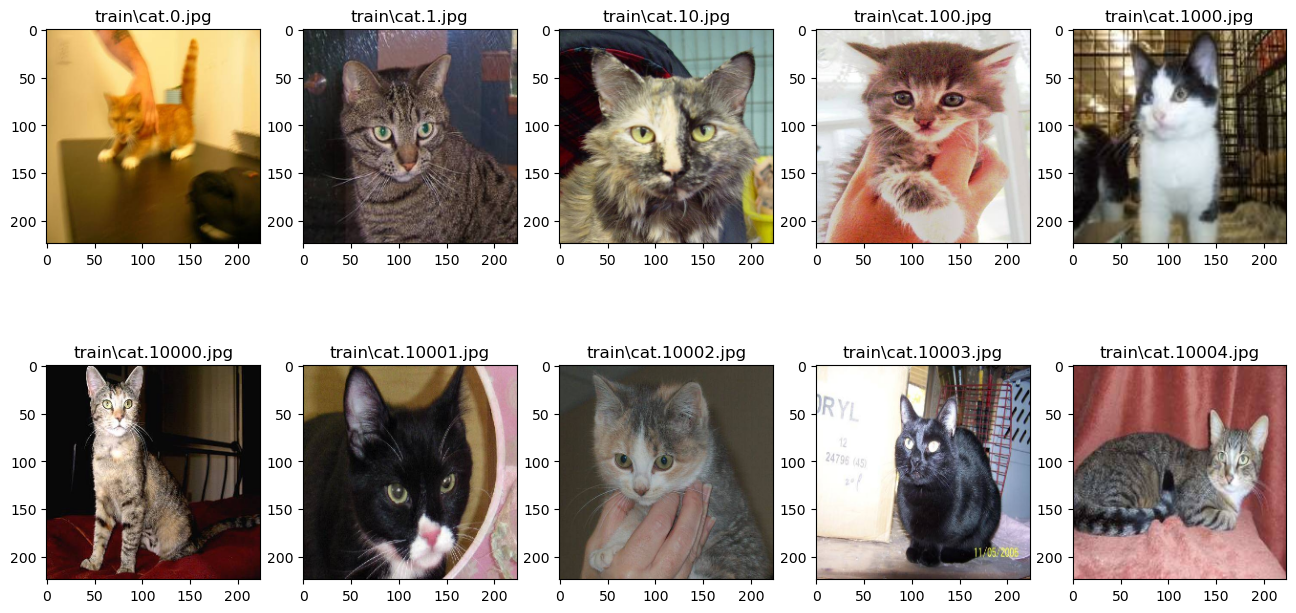

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Loading pretrained model

In [18]:
# base_model - keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [19]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Adding a fully connected layer

In [20]:
# fixing the weights of the pre-trained network
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1,  # one way out (binary classification)
                          activation='sigmoid',   
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Model architecture

In [21]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

## Compiling the model and starting the training

In [22]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [23]:
test_size = 0.3
val_samples = int(test_size * len(train_files))

shuffle(train_files)  
validation_data = next(fit_generator(train_files[:val_samples], batch_size=32))
train_data = fit_generator(train_files[val_samples:])  


model.fit(train_data,
          steps_per_epoch=10,  
          epochs=60, 
          validation_data=validation_data)

Epoch 1/60
10/10 [==============================] - 21s 2s/step - loss: 0.5639 - accuracy: 0.7063 - val_loss: 0.7367 - val_accuracy: 0.7812
Epoch 2/60
10/10 [==============================] - 21s 2s/step - loss: 0.3893 - accuracy: 0.8219 - val_loss: 0.5627 - val_accuracy: 0.8125
Epoch 3/60
10/10 [==============================] - 24s 2s/step - loss: 0.2906 - accuracy: 0.8781 - val_loss: 0.4164 - val_accuracy: 0.8438
Epoch 4/60
10/10 [==============================] - 24s 2s/step - loss: 0.2931 - accuracy: 0.8781 - val_loss: 0.3465 - val_accuracy: 0.8438
Epoch 5/60
10/10 [==============================] - 24s 2s/step - loss: 0.2923 - accuracy: 0.8906 - val_loss: 0.2439 - val_accuracy: 0.9062
Epoch 6/60
10/10 [==============================] - 25s 2s/step - loss: 0.2746 - accuracy: 0.8687 - val_loss: 0.2158 - val_accuracy: 0.9375
Epoch 7/60
10/10 [==============================] - 26s 3s/step - loss: 0.2617 - accuracy: 0.8781 - val_loss: 0.1969 - val_accuracy: 0.9375
Epoch 8/60
10/10 [==

In [24]:
model.save('cats-dogs-vgg16.keras')

## Predictions  on test dataset

In [25]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 1016s 81ms/step


C:\Users\lokky\AppData\Local\Temp\ipykernel_27672\2648597163.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  subplot.set_title('%.2f %s' % (score, os.path.basename(path)))


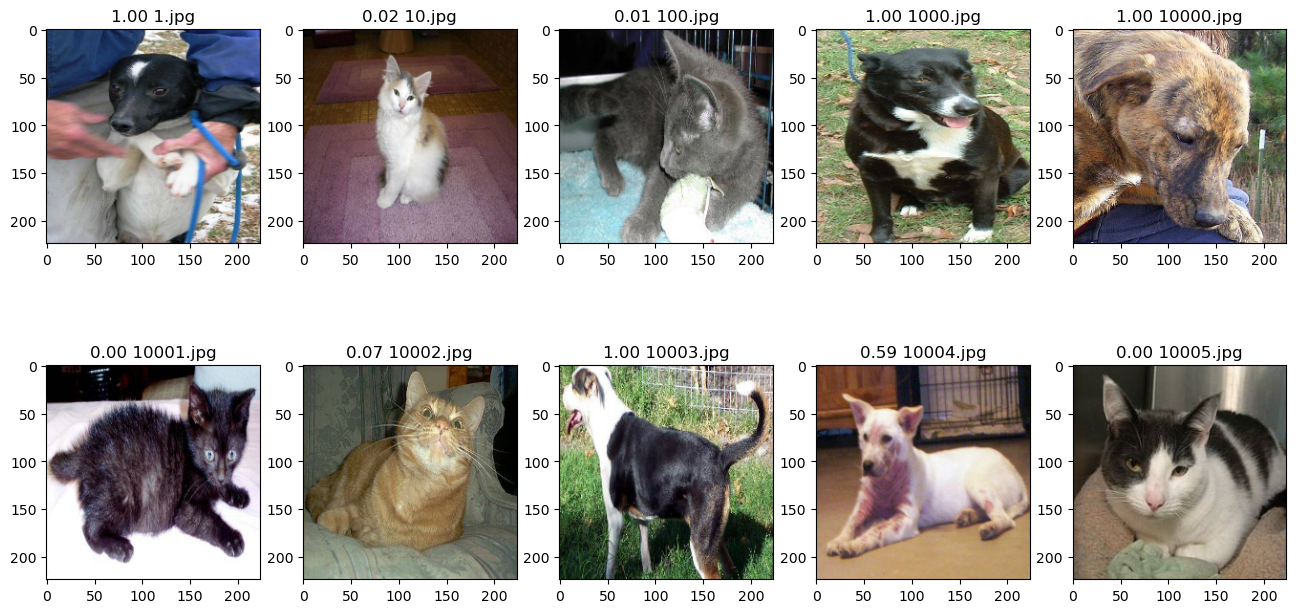

In [26]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Preparation data for sending

In [27]:
import re

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

C:\Users\lokky\AppData\Local\Temp\ipykernel_27672\2367134345.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))


The training was conducted on 60 epochs and the result was Log Loss 0.13679

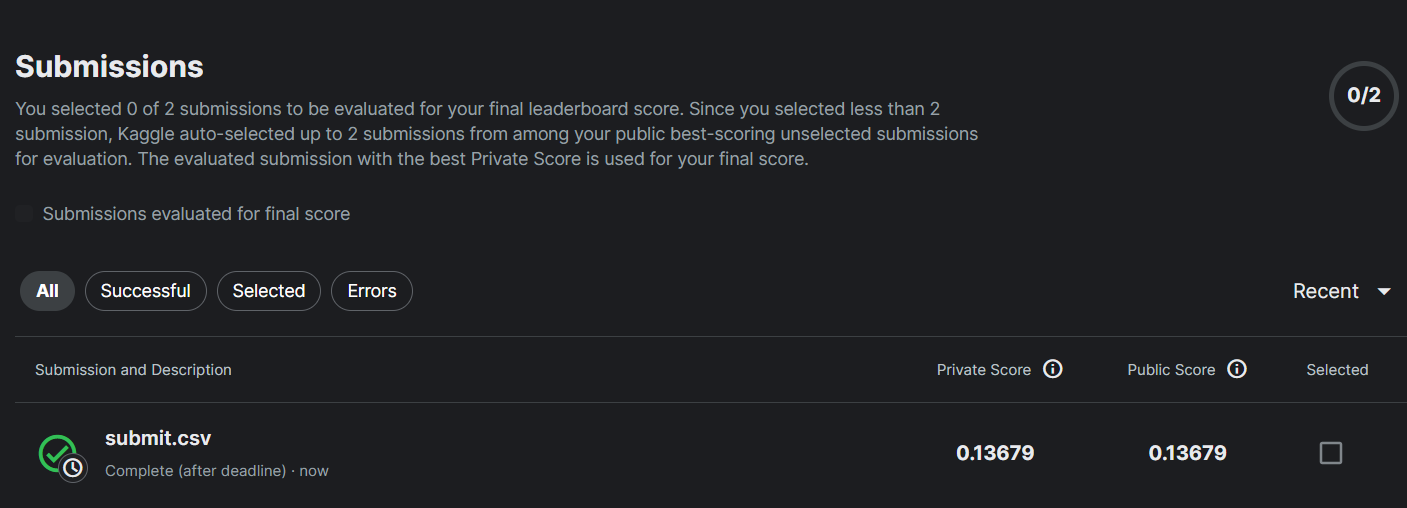